In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sympy.integrals.quadrature import gauss_legendre
import itertools
import scipy.special
import scipy.optimize
from IPython.display import display, update_display
from custom_types import *
from typing import Optional

Rendering cost field


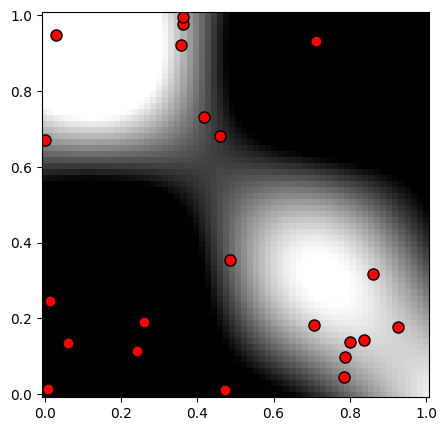

In [12]:
def render_instance(
  instance: Instance,
  resolution: int = 64,
  solution: Optional[Solution]=None,
  solution_resolution: int = 100,
  verbose: bool=True
) -> None:
  cost, cities = instance

  cost_samples = np.empty((resolution, resolution))

  if verbose:
    print("Rendering cost field")
  for v, u in tqdm(itertools.product(range(resolution), range(resolution)), total=resolution*resolution, disable=not verbose, leave=False):
    y = v/(resolution-1)
    x = u/(resolution-1)
    cost_samples[v, u] = max(min(cost.subs("x", x).subs("y", y), 1.6), 0.9)

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.pcolor(np.linspace(0, 1, resolution), np.linspace(0, 1, resolution), cost_samples, cmap="gray")

  for city in cities:
    ax.scatter(*city, c="red", edgecolors="black", s=64)
  
  if solution is not None:
    if verbose:
      print("Rendering solution")
    xs = []
    ys = []
    ts = np.linspace(0, 1, solution_resolution)
    sol_x, sol_y = solution
    for t in tqdm(ts, leave=False, disable=not verbose):
      xs.append(sol_x.subs("t", t))
      ys.append(sol_y.subs("t", t))
    
    ax.plot(xs, ys, c="lime", lw=2)
  
  return fig

if __name__ == "__main__":
  with open("sample_instances/sample_1.dat", "rb") as fp:
    sample = pickle.load(fp)
  
  render_instance(sample, resolution=64)

In [13]:
def lerp(a: float, b: float, t: float) -> float:
  return a + (b-a) * t


def inv_lerp(a: float, b: float, t: float) -> float:
  return (t-a)/(b-a)


def curve_from_polygon(vertices: Polygon) -> Solution:
  solution_x_conditions = []
  solution_y_conditions = []
  t = sympy.symbols("t")
  num_vertices = len(vertices)
  dt = 1/num_vertices
  for i, vertex in enumerate(vertices):
    t_ = inv_lerp(i*dt, (i+1)*dt, t)
    nxt = vertices[(i+1)%num_vertices]
    condition = (t <= (i+1)*dt)
    solution_x_conditions.append((lerp(vertex[0], nxt[0], t_), condition))
    solution_y_conditions.append((lerp(vertex[1], nxt[1], t_), condition))
  return (
    sympy.Piecewise(*solution_x_conditions, (0, True)),
    sympy.Piecewise(*solution_y_conditions, (0, True))
  )

In [14]:
n=128
n_digits=16
ts, ws = gauss_legendre(n, n_digits)
ts = list(float(t) for t in ts)
ws = list(float(w) for w in ws)
def evaluate_cost(instance: Instance, solution: Solution, verbose: bool = False, alpha: float = 1) -> float:
  cost_func, cities = instance
  sol_x, sol_y = solution

  dx_dt = sympy.diff(sol_x, "t")
  dy_dt = sympy.diff(sol_y, "t")
  cost_at_curve = cost_func.subs("x", sol_x).subs("y", sol_y)
  cost_along_curve = cost_at_curve*((dx_dt*dx_dt + dy_dt*dy_dt))

  s = 0
  for t, w in tqdm(zip(ts, ws), total=n, leave=False, disable=not verbose):
    if t < 0:
      continue
    s += w*cost_along_curve.subs("t", t)
  
  t = 0
  for city in tqdm(cities, leave=False, disable=not verbose):
    distance_to_city = ((sol_x-city[0])**2 + (sol_y-city[1])**2)
    func = sympy.lambdify("t", distance_to_city)
    # func = lambda t: distance_to_city.subs("t", t[0] if type(t) == np.ndarray else t)
    tax = scipy.optimize.minimize(func, 0.5, bounds=((0, 1),), options={"disp": False})
    t += func(tax.x[0])

  return s + t*alpha


In [15]:
# def taylor_polynomial(cost: CostFunction, a: float=0.5, b: float=0.5, n_terms=5, verbose: bool=False) -> CostFunction:
#   x, y = sympy.symbols("x y")
#   series = 0
#   diff_cache = {0: {0: cost}}
#   fact_rec = 1
#   with tqdm(total=n_terms*(n_terms+1)//2-1, disable=not verbose, leave=False) as pbar:
#     for dx in range(n_terms):
#       if dx > 0:
#         diff_cache[dx] = {0: sympy.diff(diff_cache[dx-1][0], x)}
#         pbar.update()
#       for dy in range(n_terms-dx):
#         if dy > 0:
#           diff_cache[dx][dy] = sympy.diff(diff_cache[dx][dy-1], y)
#           pbar.update()

#   with tqdm(total=n_terms*(n_terms+1)//2, disable=not verbose, leave=False) as pbar:
#     for n in range(n_terms):
#       fact_rec /= (n+1)
#       for i in range(n+1):
#         coeff = scipy.special.comb(n, i)
#         diff = diff_cache[i][n-i]
#         series += fact_rec * coeff * diff.subs(x, a).subs(y, b) * ((x-a)**i) * ((y-b)**(n-i))
#         pbar.update()
  
#   return series

In [16]:
# tay = taylor_polynomial(sample[0], n_terms=7, verbose=True)

In [17]:
# render_instance((tay, []), resolution=16)

In [18]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


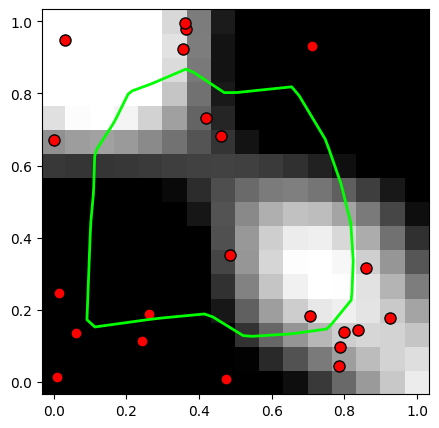

Iteration 0 - Cost: 47.04013 - Learning rate: 0.10000


100%|██████████| 20/20 [03:27<00:00, 10.36s/it]


Iteration 1 - Cost: 29.03620 - Learning rate: 0.09500


100%|██████████| 20/20 [04:51<00:00, 14.60s/it]


Iteration 2 - Cost: 19.56387 - Learning rate: 0.09025


100%|██████████| 20/20 [05:01<00:00, 15.05s/it]


Iteration 3 - Cost: 15.91558 - Learning rate: 0.08574


100%|██████████| 20/20 [05:05<00:00, 15.26s/it]


Iteration 4 - Cost: 12.89364 - Learning rate: 0.08145


100%|██████████| 20/20 [04:54<00:00, 14.74s/it]


Iteration 5 - Cost: 12.09189 - Learning rate: 0.07738


100%|██████████| 20/20 [05:05<00:00, 15.29s/it]


Iteration 6 - Cost: 11.25169 - Learning rate: 0.07351


100%|██████████| 20/20 [05:24<00:00, 16.24s/it]


Iteration 7 - Cost: 10.47398 - Learning rate: 0.06983


100%|██████████| 20/20 [05:15<00:00, 15.77s/it]


Iteration 8 - Cost: 10.18772 - Learning rate: 0.06634


100%|██████████| 20/20 [05:19<00:00, 15.95s/it]


Iteration 9 - Cost: 9.73584 - Learning rate: 0.06302


100%|██████████| 20/20 [06:02<00:00, 18.13s/it]


Iteration 10 - Cost: 9.32108 - Learning rate: 0.05987


100%|██████████| 20/20 [06:14<00:00, 18.72s/it]


Iteration 11 - Cost: 9.28133 - Learning rate: 0.05688


100%|██████████| 20/20 [06:26<00:00, 19.30s/it]


Iteration 12 - Cost: 9.27605 - Learning rate: 0.05404


100%|██████████| 20/20 [06:19<00:00, 18.97s/it]


Iteration 13 - Cost: 9.11188 - Learning rate: 0.05133


100%|██████████| 20/20 [05:58<00:00, 17.93s/it]


Iteration 14 - Cost: 9.09011 - Learning rate: 0.04877


100%|██████████| 20/20 [06:08<00:00, 18.44s/it]


Iteration 15 - Cost: 9.03881 - Learning rate: 0.04633


100%|██████████| 20/20 [05:55<00:00, 17.77s/it]


Iteration 16 - Cost: 8.80979 - Learning rate: 0.04401


100%|██████████| 20/20 [05:30<00:00, 16.52s/it]


Iteration 17 - Cost: 8.79468 - Learning rate: 0.04181


100%|██████████| 20/20 [05:56<00:00, 17.84s/it]


Iteration 18 - Cost: 8.72891 - Learning rate: 0.03972


100%|██████████| 20/20 [06:21<00:00, 19.07s/it]


Iteration 19 - Cost: 8.69244 - Learning rate: 0.03774


100%|██████████| 20/20 [06:43<00:00, 20.20s/it]


Iteration 20 - Cost: 8.68880 - Learning rate: 0.03585


100%|██████████| 20/20 [06:47<00:00, 20.38s/it]


Iteration 21 - Cost: 8.65661 - Learning rate: 0.03406


100%|██████████| 20/20 [06:44<00:00, 20.23s/it]


Iteration 22 - Cost: 8.55067 - Learning rate: 0.03235


100%|██████████| 20/20 [06:09<00:00, 18.45s/it]


Iteration 23 - Cost: 8.54075 - Learning rate: 0.03074


100%|██████████| 20/20 [06:17<00:00, 18.85s/it]


Iteration 24 - Cost: 8.53808 - Learning rate: 0.02920


100%|██████████| 20/20 [05:38<00:00, 16.93s/it]


Iteration 25 - Cost: 8.51774 - Learning rate: 0.02774


100%|██████████| 20/20 [05:24<00:00, 16.20s/it]


Iteration 26 - Cost: 8.51594 - Learning rate: 0.02635


100%|██████████| 20/20 [05:34<00:00, 16.72s/it]


Iteration 27 - Cost: 8.50269 - Learning rate: 0.02503


100%|██████████| 20/20 [09:51<00:00, 29.58s/it]


Iteration 28 - Cost: 8.47989 - Learning rate: 0.02378


100%|██████████| 20/20 [05:43<00:00, 17.17s/it]


Iteration 29 - Cost: 8.47378 - Learning rate: 0.02259


100%|██████████| 20/20 [06:02<00:00, 18.11s/it]


Iteration 30 - Cost: 8.44499 - Learning rate: 0.02146


100%|██████████| 20/20 [06:19<00:00, 18.95s/it]


Iteration 31 - Cost: 8.44054 - Learning rate: 0.02039


100%|██████████| 20/20 [06:15<00:00, 18.78s/it]


Iteration 32 - Cost: 8.43355 - Learning rate: 0.01937


100%|██████████| 20/20 [05:55<00:00, 17.80s/it]


Iteration 33 - Cost: 8.42398 - Learning rate: 0.01840


100%|██████████| 20/20 [05:43<00:00, 17.17s/it]


Iteration 34 - Cost: 8.42078 - Learning rate: 0.01748


100%|██████████| 20/20 [42:44<00:00, 128.21s/it]


Iteration 35 - Cost: 8.41689 - Learning rate: 0.01661


100%|██████████| 20/20 [08:04<00:00, 24.20s/it]


Iteration 36 - Cost: 8.41511 - Learning rate: 0.01578


100%|██████████| 20/20 [06:31<00:00, 19.60s/it]


Iteration 37 - Cost: 8.41337 - Learning rate: 0.01499


100%|██████████| 20/20 [05:54<00:00, 17.73s/it]


Iteration 38 - Cost: 8.40718 - Learning rate: 0.01424


100%|██████████| 20/20 [05:48<00:00, 17.44s/it]


Iteration 39 - Cost: 8.40223 - Learning rate: 0.01353


100%|██████████| 20/20 [05:42<00:00, 17.11s/it]


Iteration 40 - Cost: 8.39943 - Learning rate: 0.01285


100%|██████████| 20/20 [05:57<00:00, 17.89s/it]


Iteration 41 - Cost: 8.39539 - Learning rate: 0.01221


100%|██████████| 20/20 [05:47<00:00, 17.39s/it]


Iteration 42 - Cost: 8.38971 - Learning rate: 0.01160


100%|██████████| 20/20 [05:59<00:00, 17.99s/it]


Iteration 43 - Cost: 8.38788 - Learning rate: 0.01102


100%|██████████| 20/20 [05:56<00:00, 17.81s/it]


Iteration 44 - Cost: 8.38596 - Learning rate: 0.01047


100%|██████████| 20/20 [05:44<00:00, 17.22s/it]


Iteration 45 - Cost: 8.38001 - Learning rate: 0.00994


100%|██████████| 20/20 [05:45<00:00, 17.26s/it]


Iteration 46 - Cost: 8.37872 - Learning rate: 0.00945


100%|██████████| 20/20 [07:20<00:00, 22.01s/it]


Iteration 47 - Cost: 8.37482 - Learning rate: 0.00897


100%|██████████| 20/20 [06:21<00:00, 19.08s/it]


Iteration 48 - Cost: 8.37232 - Learning rate: 0.00853


100%|██████████| 20/20 [07:20<00:00, 22.01s/it]


Iteration 49 - Cost: 8.36950 - Learning rate: 0.00810


100%|██████████| 20/20 [05:47<00:00, 17.39s/it]


Iteration 50 - Cost: 8.36945 - Learning rate: 0.00769


100%|██████████| 20/20 [05:50<00:00, 17.54s/it]


Got solution


Cost = 8.36926
Rendering cost field


Rendering solution


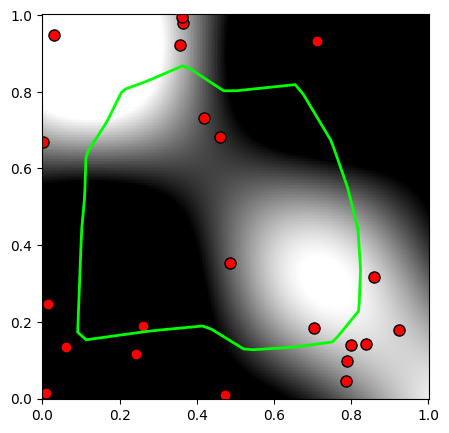

Timer unit: 1e-09 s

Total time: 20237.1 s
File: /tmp/ipykernel_35179/1740203173.py
Function: polygon_hill_climbing at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def polygon_hill_climbing(instance: Instance, verbose: bool = False) -> Solution:
     2         1       1700.0   1700.0      0.0    cost_func, cities = instance
     3                                           
     4         1        200.0    200.0      0.0    learning_rate = 0.1
     5                                             
     6         1        100.0    100.0      0.0    n = 20
     7         1      92800.0  92800.0      0.0    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
     8         1       2300.0   2300.0      0.0    vertices = np.empty((n, 2))
     9         1      30700.0  30700.0      0.0    vertices[:, 0] = np.maximum(0, np.minimum(1, 2 * np.cos(angles) + 0.5))
    10         1      20800.0  20800.0      0.0    vertices[:, 

In [19]:
def polygon_hill_climbing(instance: Instance, verbose: bool = False) -> Solution:
  cost_func, cities = instance

  learning_rate = 0.1
  
  n = 20
  angles = np.linspace(0, 2*np.pi, n, endpoint=False)
  vertices = np.empty((n, 2))
  vertices[:, 0] = np.maximum(0, np.minimum(1, 2 * np.cos(angles) + 0.5))
  vertices[:, 1] = np.maximum(0, np.minimum(1, 2 * np.sin(angles) + 0.5))

  cost = evaluate_cost(instance, curve_from_polygon(list(tuple(x) for x in vertices)), alpha=10)
  yield curve_from_polygon(list(tuple(x) for x in vertices))
  # df_dx = sympy.diff(cost_func, "x")
  # df_dy = sympy.diff(cost_func, "y")

  it = 0
  changed = True
  while changed:
    if verbose:
      print(f"Iteration {it} - Cost: {cost:.5f} - Learning rate: {learning_rate:.5f}")
    changed = False
    for i in tqdm(range(n), disable=not verbose):
      x, y = vertices[i]
      angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
      min_cost = cost
      min_cost_idx = None
      for idx, angle in enumerate(angles):
        # df_dx_ = df_dx.subs("x", x).subs("y", y)
        # df_dy_ = df_dy.subs("x", x).subs("y", y)
        vertices[i][0] = np.maximum(0, np.minimum(1, x - np.cos(angle) * learning_rate))
        vertices[i][1] = np.maximum(0, np.minimum(1, y - np.sin(angle) * learning_rate))
        poly = curve_from_polygon(list(tuple(x) for x in vertices))
        new_cost = evaluate_cost(instance, poly, alpha=10)
        if new_cost < min_cost:
          min_cost = new_cost
          min_cost_idx = idx
          yield poly
      
      if min_cost_idx is not None:
        angle = angles[min_cost_idx]
        vertices[i][0] = np.maximum(0, np.minimum(1, x - np.cos(angle) * learning_rate))
        vertices[i][1] = np.maximum(0, np.minimum(1, y - np.sin(angle) * learning_rate))
        cost = min_cost
        changed = True
      else:
        vertices[i][0] = x
        vertices[i][1] = y
        
    it += 1
    learning_rate *= 0.95
    if it > 50:
      break
  
  yield curve_from_polygon(list(tuple(x) for x in vertices))

if __name__ == "__main__":
  def main():
    fig = render_instance(sample, resolution=16, verbose=False)
    display(fig, display_id="plot")
    for solution in polygon_hill_climbing(sample, verbose=True):
      plt.close()
      fig = render_instance(sample, resolution=16, solution=solution, verbose=False)
      update_display(fig, display_id="plot")
    plt.close()

    print("Got solution")
    cost = evaluate_cost(sample, solution, verbose=True, alpha=10)

    print(f"Cost = {cost:.5f}")

    render_instance(sample, resolution=256, solution=solution)
  
  try:
    %lprun -f polygon_hill_climbing -f curve_from_polygon -f evaluate_cost main()
    # main()
  except KeyboardInterrupt:
    pass